In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/Midterm Thesis/dataset/DATASET15.zip', 'r')
zip_ref.extractall('/content/maindataset')
zip_ref.close()

In [4]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
#from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_path = '/content/maindataset/DATASET15/TRAIN'
test_path = '/content/maindataset/DATASET15/TEST'

In [6]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['O', 'R'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['O', 'R'], batch_size=10)


Found 21504 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


In [7]:
# plot function, used to plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

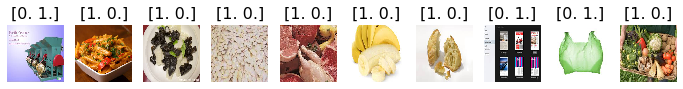

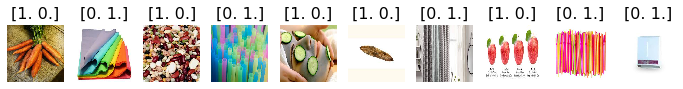

In [9]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)
imgs, labels = next(test_batches)
plots(imgs, titles=labels)

### **Data Augmentation**

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2, 
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                rescale=1./255, validation_split=0.15)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_path, class_mode = 'binary',
                                              batch_size = 32, 
                                              target_size=(65,65), subset='training')

val_set = train_datagen.flow_from_directory(train_path, class_mode = 'binary',
                                              batch_size = 32, 
                                              target_size=(65,65), subset='validation')

test_set = test_datagen.flow_from_directory(test_path, class_mode = 'binary',
                                              batch_size = 32, 
                                              target_size=(65,65))


Found 18279 images belonging to 2 classes.
Found 3225 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


## Convolution Block

In [11]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    return x

## Creating Model

In [12]:
def create_model():
    inputs = tf.keras.Input(shape=(65, 65, 3))
    
    x = conv_block(inputs, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
        
    x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
    
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    func_model = tf.keras.models.Model(inputs = inputs, outputs=output)
    
    return func_model

In [13]:
model = create_model()

## Compiling and fitting data

In [55]:
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
             
    ]
adam = tf.keras.optimizers.Adam()    
model.compile(optimizer = adam, loss ='binary_crossentropy', metrics = METRICS)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3
                                                  , patience=5, verbose=2, 
                                                  mode='max')
# Define the checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_weights.h5', save_best_only=True)

history = model.fit(train_set, validation_data = val_set, epochs =30, 
                    callbacks=[lr_reduce, checkpoint_callback])



Epoch 1/30
572/572 [==============================] - 70s 102ms/step - loss: 0.4208 - accuracy: 0.8226 - tp: 6403.0000 - fp: 1500.0000 - tn: 8634.0000 - fn: 1742.0000 - precision: 0.8102 - recall: 0.7861 - val_loss: 0.4998 - val_accuracy: 0.8003 - val_tp: 1320.0000 - val_fp: 527.0000 - val_tn: 1261.0000 - val_fn: 117.0000 - val_precision: 0.7147 - val_recall: 0.9186 - lr: 0.0010
Epoch 2/30
572/572 [==============================] - 61s 106ms/step - loss: 0.3972 - accuracy: 0.8324 - tp: 6588.0000 - fp: 1506.0000 - tn: 8628.0000 - fn: 1557.0000 - precision: 0.8139 - recall: 0.8088 - val_loss: 0.4352 - val_accuracy: 0.8121 - val_tp: 954.0000 - val_fp: 123.0000 - val_tn: 1665.0000 - val_fn: 483.0000 - val_precision: 0.8858 - val_recall: 0.6639 - lr: 0.0010
Epoch 3/30
572/572 [==============================] - 57s 100ms/step - loss: 0.4031 - accuracy: 0.8350 - tp: 6665.0000 - fp: 1536.0000 - tn: 8598.0000 - fn: 1480.0000 - precision: 0.8127 - recall: 0.8183 - val_loss: 0.3267 - val_accuracy

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 65, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 65, 65, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 65, 65, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 65, 65, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496 

In [57]:
model.evaluate(test_set)

112/112 [==============================] - 5s 43ms/step - loss: 0.3276 - accuracy: 0.8774 - tp: 1377.0000 - fp: 286.0000 - tn: 1758.0000 - fn: 152.0000 - precision: 0.8280 - recall: 0.9006


[0.3275892734527588,
 0.8774139285087585,
 1377.0,
 286.0,
 1758.0,
 152.0,
 0.8280216455459595,
 0.9005886316299438]

In [58]:
test_loss, test_acc, true_positives, false_positives, true_negatives, false_negatives, precision, recall = model.evaluate(test_set)


112/112 [==============================] - 4s 38ms/step - loss: 0.3276 - accuracy: 0.8774 - tp: 1377.0000 - fp: 286.0000 - tn: 1758.0000 - fn: 152.0000 - precision: 0.8280 - recall: 0.9006


In [60]:
# Compute the confusion matrix
confusion_mtx = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

print(confusion_mtx)


[[1758.  286.]
 [ 152. 1377.]]


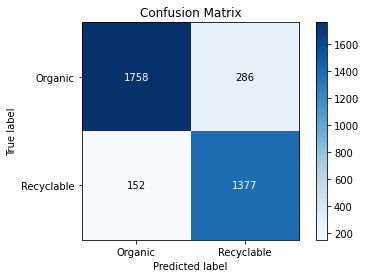

In [61]:
# Define the class names for the matrix
class_names = ['Organic', 'Recyclable']

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for the chart
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations to the chart
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()


# Plot

Text(0.5, 1.0, 'Training and validation loss')

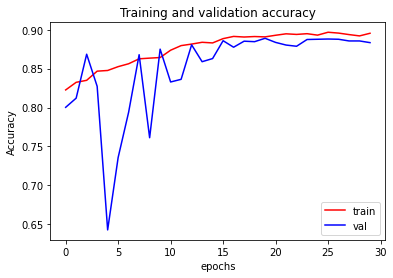

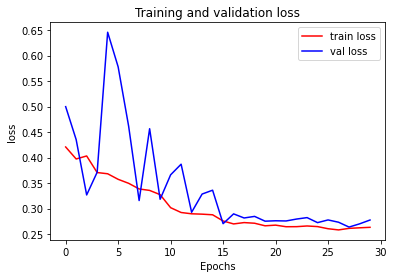

In [62]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
#print(history.history['lr'])
epochs=range(len(acc)) # Get number of epochs
rec = history.history['recall']
per = history.history['precision']
val_rec = history.history['val_recall']
val_perc = history.history['val_precision']


# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

## vgg16 Model Building

In [63]:
from keras.applications.vgg16 import VGG16
#vgg16_model = VGG16()

In [64]:
# Defining Model
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [65]:
# Freezing Layers 
for layer in base_model.layers:
    layer.trainable=False

In [66]:
# Summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [67]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.15)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.15)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [68]:
train_set  = train_datagen.flow_from_directory(train_path,
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

val_set = valid_datagen.flow_from_directory(train_path,
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')
test_set = test_datagen.flow_from_directory(test_path, class_mode = 'binary',
                                              batch_size = 128, 
                                              target_size=(224, 224))

Found 18279 images belonging to 2 classes.
Found 3225 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


In [69]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [70]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1024)              25691136  
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [71]:
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
          tf.metrics.AUC(name='auc')
          
    ]
# Model Compile 
OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              metrics= METRICS,
              optimizer=OPT)

In [72]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [73]:
# Model Fitting 
model_history=model.fit(train_set,
                        validation_data=val_set,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8631 - tp: 6833.0000 - fp: 1191.0000 - tn: 8943.0000 - fn: 1312.0000 - precision: 0.8516 - recall: 0.8389 - auc: 0.9334
Epoch 1: val_auc improved from -inf to 0.94135, saving model to ./best_weights.hdf5
143/143 [==============================] - 334s 2s/step - loss: 0.3369 - accuracy: 0.8631 - tp: 6833.0000 - fp: 1191.0000 - tn: 8943.0000 - fn: 1312.0000 - precision: 0.8516 - recall: 0.8389 - auc: 0.9334 - val_loss: 0.3171 - val_accuracy: 0.8781 - val_tp: 1168.0000 - val_fp: 124.0000 - val_tn: 1664.0000 - val_fn: 269.0000 - val_precision: 0.9040 - val_recall: 0.8128 - val_auc: 0.9414
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.8966 - tp: 7168.0000 - fp: 913.0000 - tn: 9221.0000 - fn: 977.0000 - precision: 0.8870 - recall: 0.8800 - auc: 0.9578
Epoch 2: val_auc improved from 0.94135 to 0.95946, saving model to ./best_weights.hdf5
143/143 [============

In [74]:
model.evaluate(test_set)

28/28 [==============================] - 25s 904ms/step - loss: 0.3827 - accuracy: 0.8847 - tp: 1266.0000 - fp: 149.0000 - tn: 1895.0000 - fn: 263.0000 - precision: 0.8947 - recall: 0.8280 - auc: 0.9373


[0.38266196846961975,
 0.8846907615661621,
 1266.0,
 149.0,
 1895.0,
 263.0,
 0.8946996331214905,
 0.8279921412467957,
 0.9373012781143188]

In [75]:
test_loss, test_acc, true_positives, false_positives, true_negatives, false_negatives, precision, recall, auc = model.evaluate(test_set)

28/28 [==============================] - 16s 562ms/step - loss: 0.3827 - accuracy: 0.8847 - tp: 1266.0000 - fp: 149.0000 - tn: 1895.0000 - fn: 263.0000 - precision: 0.8947 - recall: 0.8280 - auc: 0.9373


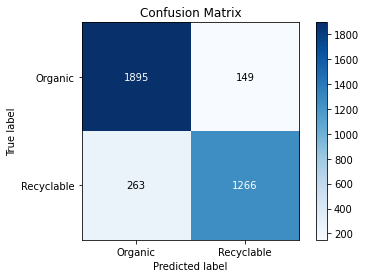

In [76]:
# Compute the confusion matrix
confusion_mtx = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
# Define the class names for the matrix
class_names = ['Organic', 'Recyclable']

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for the chart
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations to the chart
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()

Text(0.5, 1.0, 'Training and validation loss')

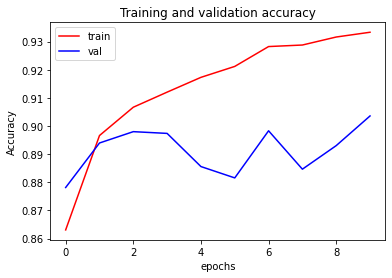

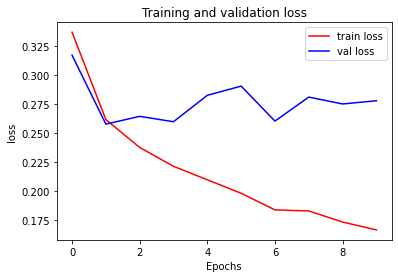

In [77]:
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

In [78]:
# Class Indices 
train_set.class_indices

{'O': 0, 'R': 1}

1/1 [==============================] - 1s 1s/step
The image belongs to Organic waste category 


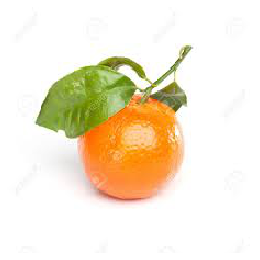

In [80]:
# Test Case:1 - ORGANIC

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/O/O_15.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 27ms/step
The image belongs to Recycle waste category


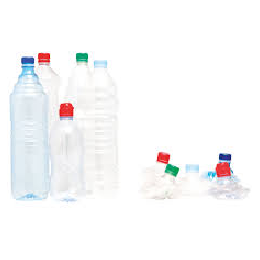

In [83]:
# Test Case:2 - RECYCLE

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/R/R_78.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")